In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from tensorflow.keras.utils import to_categorical

In [25]:
#Load csv
df = pd.read_csv("./dataset/tbpred.csv")
print(df.nunique())

Name                 1972
Gender                  2
Age                    96
CountryofBirth        243
Smoking                 5
Alcohol                 5
FamilyHistory           2
CloseContact            2
HealthConditions        2
OccupationalRisks       2
PhysicalActivity        5
Diet                    2
AirPollution            5
LongTermCough           2
ChestPain               2
AppetiteLoss            2
WeightLoss              2
Chills                  2
Fatigue                 2
NightSweat              2
CoughBlood              2
Fevers                  2
NitricOxide          1679
tb_pred                 2
dtype: int64


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               2000 non-null   object 
 1   Gender             2000 non-null   int64  
 2   Age                2000 non-null   int64  
 3   CountryofBirth     2000 non-null   object 
 4   Smoking            2000 non-null   int64  
 5   Alcohol            2000 non-null   int64  
 6   FamilyHistory      2000 non-null   int64  
 7   CloseContact       2000 non-null   int64  
 8   HealthConditions   2000 non-null   int64  
 9   OccupationalRisks  2000 non-null   int64  
 10  PhysicalActivity   2000 non-null   int64  
 11  Diet               2000 non-null   int64  
 12  AirPollution       2000 non-null   int64  
 13  LongTermCough      2000 non-null   int64  
 14  ChestPain          2000 non-null   int64  
 15  AppetiteLoss       2000 non-null   int64  
 16  WeightLoss         2000 

In [27]:
print(df.isnull().sum())
print('Total number of duplicated rows: ', df.duplicated().sum())

Name                 0
Gender               0
Age                  0
CountryofBirth       0
Smoking              0
Alcohol              0
FamilyHistory        0
CloseContact         0
HealthConditions     0
OccupationalRisks    0
PhysicalActivity     0
Diet                 0
AirPollution         0
LongTermCough        0
ChestPain            0
AppetiteLoss         0
WeightLoss           0
Chills               0
Fatigue              0
NightSweat           0
CoughBlood           0
Fevers               0
NitricOxide          0
tb_pred              0
dtype: int64
Total number of duplicated rows:  0


In [28]:
df_cat = df[['Name', 'CountryofBirth']]

In [29]:
#Label Encode 'Country of Birth' 
le = preprocessing.LabelEncoder()
df['encoded_country'] = le.fit_transform(df['CountryofBirth'])

print(df.sample(5))

                 Name  Gender  Age            CountryofBirth  Smoking  \
805    Hayden Roberts       1   56  United States of America        2   
236   Katrina Cochran       0   34                   Comoros        3   
1301   Brandon Howard       1   16                    Panama        3   
1305     Gabriel Hill       0   31                     Japan        1   
1888     Cristian Lee       0   56                    Canada        1   

      Alcohol  FamilyHistory  CloseContact  HealthConditions  \
805         2              0             0                 0   
236         4              0             0                 0   
1301        4              0             1                 0   
1305        1              1             0                 0   
1888        1              0             1                 0   

      OccupationalRisks  ...  AppetiteLoss  WeightLoss  Chills  Fatigue  \
805                   0  ...             0           1       0        0   
236                   0  .

In [30]:
X = df.drop(['Name','CountryofBirth'], axis=1)
print(X.sample(5))

      Gender  Age  Smoking  Alcohol  FamilyHistory  CloseContact  \
1554       1   43        2        4              0             0   
1943       1   28        4        0              1             1   
808        0   96        2        3              0             0   
1637       0   38        0        4              0             0   
231        1   83        1        1              0             0   

      HealthConditions  OccupationalRisks  PhysicalActivity  Diet  ...  \
1554                 1                  1                 2     1  ...   
1943                 1                  1                 4     0  ...   
808                  0                  1                 2     1  ...   
1637                 1                  0                 1     0  ...   
231                  1                  1                 0     1  ...   

      AppetiteLoss  WeightLoss  Chills  Fatigue  NightSweat  CoughBlood  \
1554             0           0       1        1           1           0

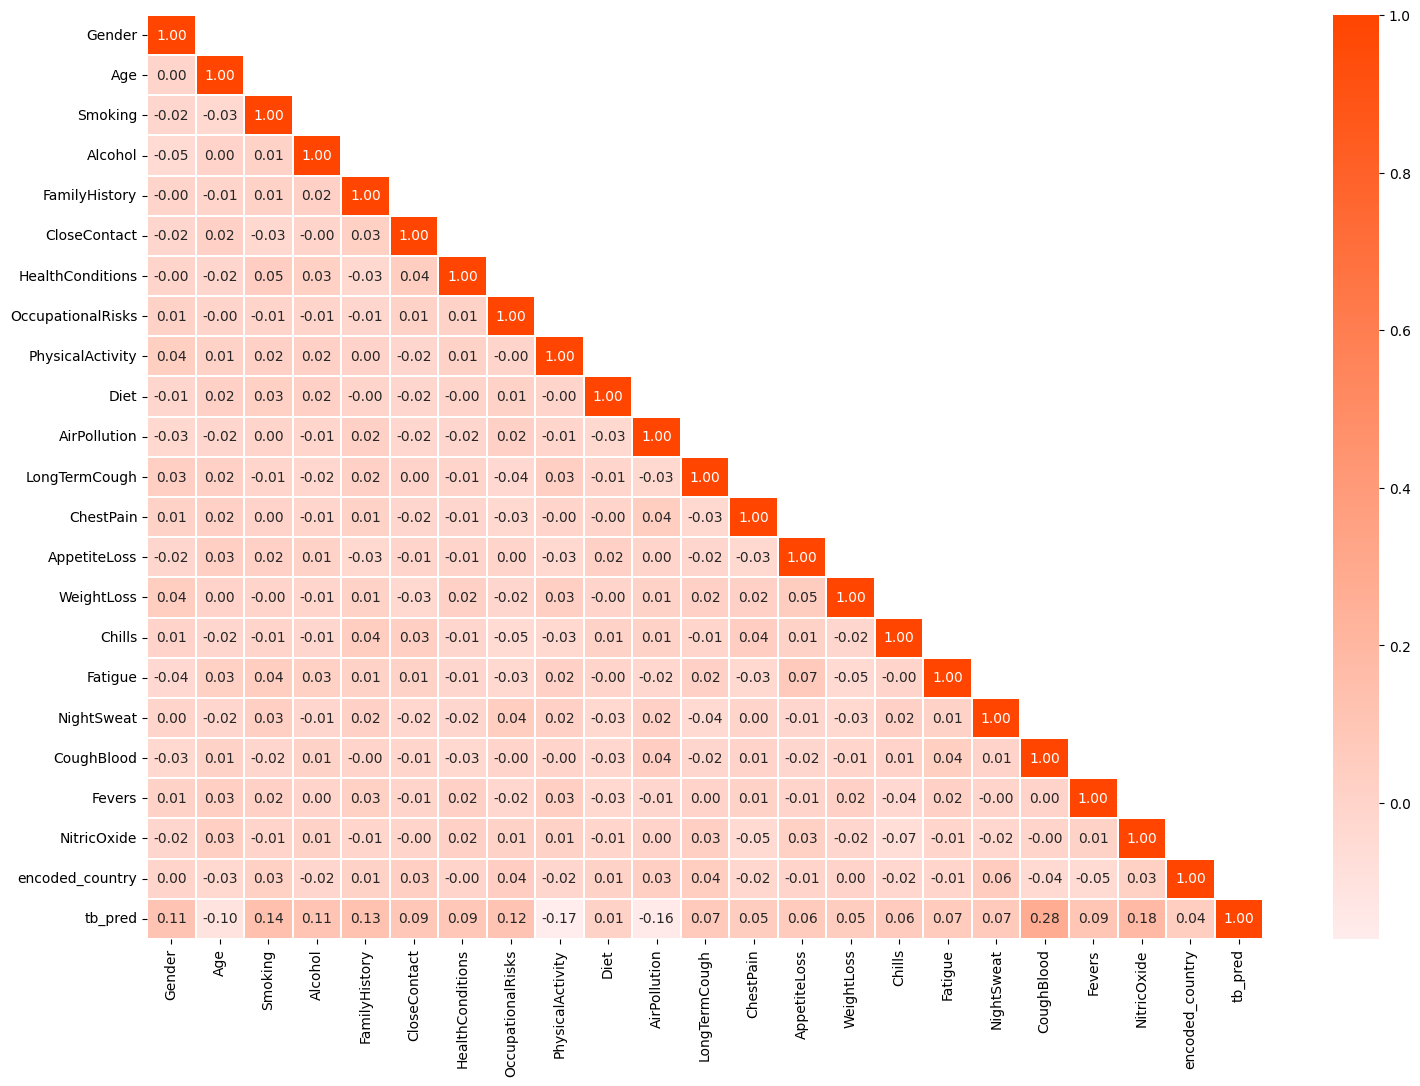

In [31]:
# Define a colormap
orangered_cmap = LinearSegmentedColormap.from_list('orangered', ['#FFECEC','orangered'])

# Calculation of the Spearman correlation
target = 'tb_pred'
df_ordered = pd.concat([X.drop(target,axis=1), X[target]],axis=1)
corr = df_ordered.corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(18,12))
sns.heatmap(corr, mask=mask, annot=True, cmap=orangered_cmap, fmt='.2f', linewidths=0.2)
plt.show()

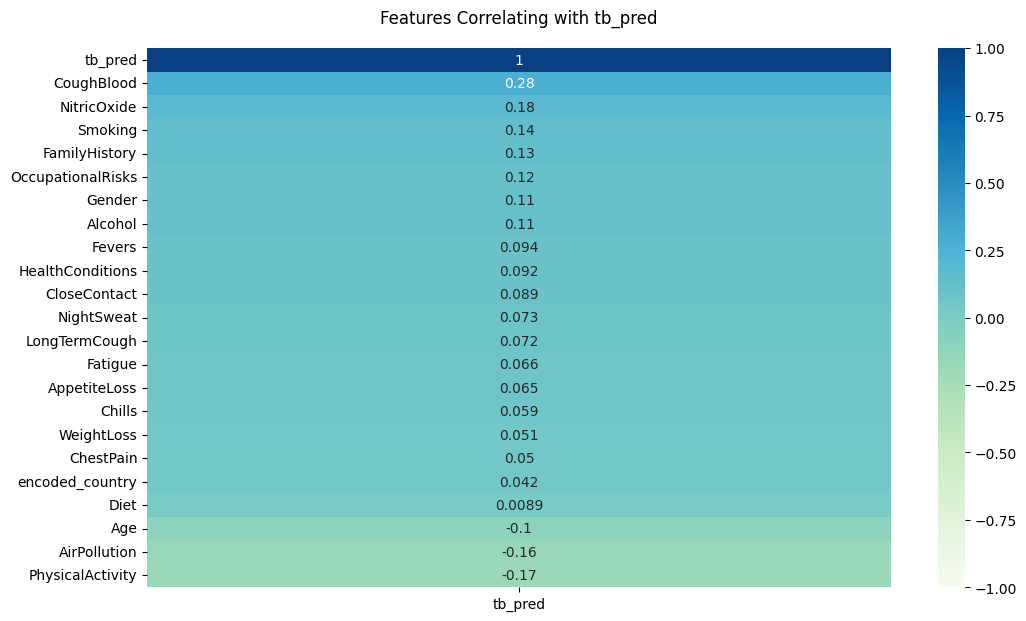

In [32]:
plt.figure (figsize = (12, 7), dpi = 100)
heatmap = sns.heatmap (X.corr()[['tb_pred']].sort_values (by = 'tb_pred', ascending = False), vmin = -1, vmax = 1, annot = True, cmap = 'GnBu')
heatmap.set_title ('Features Correlating with tb_pred', fontdict = {'fontsize':12}, pad = 18);

In [33]:
print(X['tb_pred'].value_counts())

0    1519
1     481
Name: tb_pred, dtype: int64


## Training

### Using SVM

In [34]:
X1 = X.drop('tb_pred', axis=1)
Y1 = X['tb_pred']

In [35]:
print(X1.shape)
print(Y1.shape)

(2000, 22)
(2000,)


In [36]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y1, test_size = 0.15)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1700, 22)
(300, 22)
(1700,)
(300,)


In [38]:
kern = ['linear','rbf','poly']
for ke in kern:
    model = SVC(kernel=ke, C=300)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print(ke+" accuracy: ", metrics.accuracy_score(y_test, y_pred))

linear accuracy:  0.8166666666666667
rbf accuracy:  0.7966666666666666
poly accuracy:  0.79


In [39]:
for num in range(100, 600, 100):
    model = SVC(kernel='linear', C=num)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print(num, " accuracy: ", metrics.accuracy_score(y_test, y_pred))

100  accuracy:  0.8166666666666667
200  accuracy:  0.8166666666666667
300  accuracy:  0.8166666666666667
400  accuracy:  0.8166666666666667
500  accuracy:  0.8166666666666667


In [40]:
model = SVC(kernel='linear', C=300)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [41]:
# Calculate the percentage of True and False predictions
percentage_true = (y_pred == 1).sum() / len(y_pred) * 100
percentage_false = (y_pred == 0).sum() / len(y_pred) * 100

# Display the percentages
print(f"Percentage of True Predictions: {percentage_true:.2f}%")
print(f"Percentage of False Predictions: {percentage_false:.2f}%")

Percentage of True Predictions: 16.67%
Percentage of False Predictions: 83.33%


### Using KNN

In [42]:
X2 = X[['CoughBlood','OccupationalRisks','Smoking','NitricOxide','FamilyHistory']]

In [43]:
scaler = preprocessing.StandardScaler()

X1_scaled = scaler.fit_transform(X1)

X1_scaled = pd.DataFrame(X1_scaled)

X1_train,X1_test,y1_train,y1_test = train_test_split(X1_scaled, Y1, test_size = .3,random_state=5)

Text(0, 0.5, 'Accuracy')

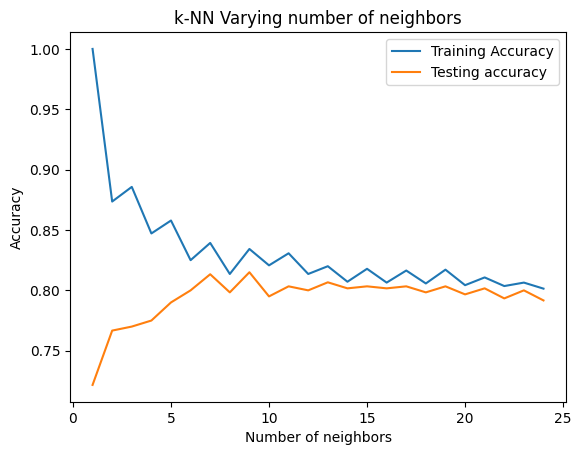

In [44]:
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,25)
scores_list = []
error_list = []
train_accuracy =np.empty(len(k_range))
test_accuracy = np.empty(len(k_range))
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(X1_train,y1_train)
        #y_pred=knn.predict(X_test)
        #scores[k] = metrics.accuracy_score(y_test,y_pred)
        #scores_list.append(metrics.accuracy_score(y_test,y_pred))
        #error_list.append(np.mean(y_pred != y_test))
        train_accuracy[k-1] = knn.score(X1_train, y1_train)
        test_accuracy[k-1] = knn.score(X1_test, y1_test)

plt.title('k-NN Varying number of neighbors')
plt.plot(k_range,train_accuracy, label='Training Accuracy')
plt.plot(k_range,test_accuracy, label='Testing accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

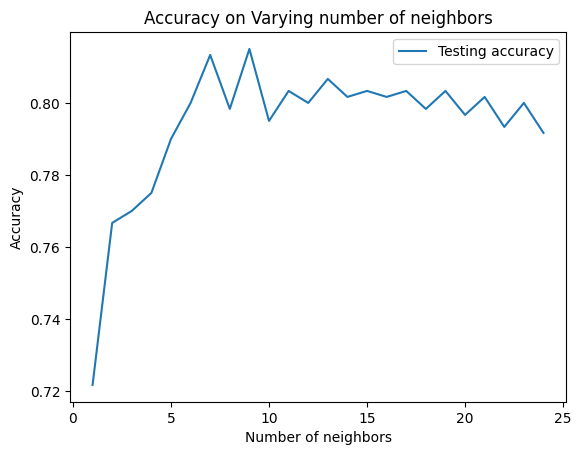

In [45]:
plt.title('Accuracy on Varying number of neighbors')
plt.plot(k_range,test_accuracy, label='Testing accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

In [99]:
knn1 = KNeighborsClassifier(n_neighbors=7, weights='uniform')

knn1.fit(X1_train,y1_train)

y_pred1 = knn1.predict(X1_test)

score = metrics.accuracy_score(y1_test, y_pred1)

print("Accuracy: ", score)

Accuracy:  0.8133333333333334


### Multi Class Classification

In [47]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(solver='liblinear', random_state = 0)
classifier.fit(X1, Y1)

LogisticRegression(random_state=0, solver='liblinear')

In [48]:
y_pred2=classifier.predict(X1)

accuracy = metrics.accuracy_score(Y1, y_pred2)
print("train accuracy: %.2f." %accuracy)

precision = metrics.precision_score(Y1, y_pred2, average='macro')
print("train precision: %.2f." %precision)

recall = metrics.recall_score(Y1, y_pred2, average='macro')
print("train recall: %.2f." %recall)

print(y_pred2[:100])

train accuracy: 0.84.
train precision: 0.79.
train recall: 0.73.
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


In [49]:
# Calculate the percentage of True and False predictions
percentage_true = (y_pred2 == 1).sum() / len(y_pred2) * 100
percentage_false = (y_pred2 == 0).sum() / len(y_pred2) * 100

# Display the percentages
print(f"Percentage of True Predictions: {percentage_true:.2f}%")
print(f"Percentage of False Predictions: {percentage_false:.2f}%")

Percentage of True Predictions: 17.35%
Percentage of False Predictions: 82.65%


## DNN

In [50]:
cmodel = tf.keras.models.Sequential()

cmodel.add(tf.keras.Input(shape=[X1.shape[1]]))

cmodel.add(tf.keras.layers.Dense(15, activation='relu'))

cmodel.add(tf.keras.layers.Dense(10, activation='relu'))

# Assuming num_classes is the number of unique classes in your data
num_classes = len(set(Y1))
cmodel.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

print(cmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                345       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 527
Trainable params: 527
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
# Encode categorical target variable
encoder = preprocessing.LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
num_classes = len(encoder.classes_)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

In [52]:
optimizer = tf.keras.optimizers.Adam()

cmodel.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

chistory = cmodel.fit(X_train, y_train_one_hot, batch_size=8, epochs=150,validation_split = 0.2, verbose=0, callbacks=[early_stop])

In [54]:
# Encode categorical target variable
encoder1 = preprocessing.LabelEncoder()
y_test_encoded = encoder1.fit_transform(y_test)
num_classes1 = len(encoder1.classes_)

# One-hot encode the labels
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes1)

# Evaluate the model
score = cmodel.evaluate(X_test, y_test_one_hot, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10/10 [==============================] - 0s 504us/step - loss: 0.4611 - accuracy: 0.8133
Test Score: 0.4610699415206909
Test Accuracy: 0.8133333325386047


In [55]:
cpredict = cmodel.predict(X_test)
print(cpredict[:10])

[[8.6108637e-01 1.3891359e-01]
 [7.4602091e-01 2.5397909e-01]
 [8.6570251e-01 1.3429749e-01]
 [9.9986434e-01 1.3565952e-04]
 [8.4191495e-01 1.5808503e-01]
 [9.9864942e-01 1.3506257e-03]
 [9.8910761e-01 1.0892367e-02]
 [9.9863428e-01 1.3657608e-03]
 [9.9991977e-01 8.0263548e-05]
 [9.8848420e-01 1.1515762e-02]]


In [56]:
print(classification_report(np.argmax(y_test_one_hot, axis=1),np.argmax(cpredict, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       227
           1       0.69      0.42      0.53        73

    accuracy                           0.81       300
   macro avg       0.76      0.68      0.70       300
weighted avg       0.80      0.81      0.80       300



## Decision Tree

In [57]:
#Train model
dt_classifier = DecisionTreeClassifier(random_state=20)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=20)

In [58]:
prediction_dt = dt_classifier.predict(X_train)
accuracy_dt = accuracy_score(y_train, prediction_dt)
print(f"Train Accuracy: {accuracy_dt}")
predictions_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, predictions_dt)
print(f"Test Accuracy: {accuracy_dt}")

Train Accuracy: 1.0
Test Accuracy: 0.8066666666666666


In [59]:
X3 = X.drop('tb_pred', axis=1)
Y3 = X['tb_pred'].values.reshape(-1, 1)

In [60]:
# Check the shape of X and y
print ('X:', X3.shape,'\nY:', Y3.shape)

X: (2000, 22) 
Y: (2000, 1)


In [61]:
# Array of test size value from 0.2 to 0.3
test_size = np.arange(start=0.2, stop=0.35, step= 0.05)

# Initialize a list where we'll store the score of each test size
score =[]
for size in test_size:
    X_train2, X_test2, y_train2, y_test2 = train_test_split (X3, Y3, test_size=size, random_state=0)
    DT_Clf = DecisionTreeClassifier (max_depth=3)
    DT_Clf.fit (X_train2, y_train2)
    score.append (DT_Clf.score (X_test2, y_test2))

# Create a dataframe to display the results 
r= pd.DataFrame({'Test size': test_size , 'Score': score})
r.sort_values(by = ['Score'], ascending = False, inplace = True)
r.style.highlight_max(color='#acd9a8')

,Test size,Score
1,0.250000,0.790000
0,0.200000,0.775000
2,0.300000,0.771667


In [63]:
# Split X and y into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split (X3, Y3, stratify=Y3, test_size = 0.25, random_state = 0)

In [64]:
# check the shape of X_train, X_test, y_train and y_test
print('X_train shape: ', X_train2.shape)
print('X_test shape: ', X_test2.shape)
print('y_train shape: ', y_train2.shape)
print('y_test shape: ', y_test2.shape)

X_train shape:  (1500, 22)
X_test shape:  (500, 22)
y_train shape:  (1500, 1)
y_test shape:  (500, 1)


In [65]:
# Instantiate the model
DT_model = DecisionTreeClassifier(max_depth=3)

# Fit the model to the training set
DT_model.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=3)

In [66]:
y_pred3 = DT_model.predict(X_test2)

In [67]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test2, y_pred3)))

Model accuracy score: 0.7640


In [68]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(DT_model.score(X_train2, y_train2)))
print('Test set score: {:.4f}'.format(DT_model.score(X_test2, y_test2)))

Training set score: 0.7967
Test set score: 0.7640


In [69]:
print(classification_report(y_test2, y_pred3))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       380
           1       0.52      0.24      0.33       120

    accuracy                           0.76       500
   macro avg       0.66      0.59      0.59       500
weighted avg       0.73      0.76      0.73       500



In [70]:
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [71]:
BaseDT_result = metrics_calculator(y_test2, y_pred3, 'Base Decision Tree')
BaseDT_result

,Base Decision Tree
Accuracy,0.764000
Precision,0.656451
Recall,0.585307
F1-score,0.593171


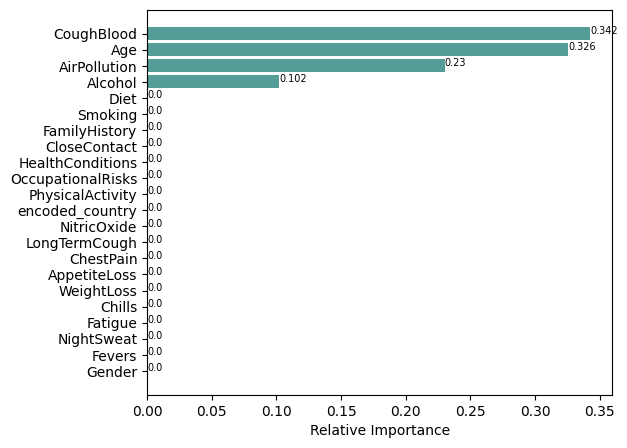

In [76]:
feature_names = X3.columns
target_names = ["0", "1", "2", "3"]

# Get feature importances from the Random Forest model
importances = DT_model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

In [78]:
# Finding optimal hyperparameters(GridSearchCV)

# Define model
model = DecisionTreeClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# Define search parameters
max_depth = range(2, 19, 1)
criterion = ['entropy', 'gini']   

#min_samples_split = [2, 3, 4]
#min_samples_leaf = [1, 2, 3]

param_grid = {'max_depth': max_depth, 'criterion':criterion}

# Define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=1, cv=cv)

# Execute search
GridSearchCV = search.fit(X_train2, y_train2)

# Set the clf to the best combination of parameters
DT_modelcv = GridSearchCV.best_estimator_

# Summarize result
print('Best Score: %s' % GridSearchCV.best_score_)
print('Best Hyperparameters: %s' % GridSearchCV.best_params_)

Best Score: 0.8175555555555555
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5}


In [79]:
DT_modelcv.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=5)

In [80]:
y_pred4 = DT_modelcv.predict(X_test2)

In [81]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test2, y_pred4)))

Model accuracy score: 0.7920


In [82]:
print(classification_report(y_test2, y_pred4))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       380
           1       0.60      0.41      0.49       120

    accuracy                           0.79       500
   macro avg       0.71      0.66      0.68       500
weighted avg       0.77      0.79      0.78       500



In [83]:
TunedDT_result = metrics_calculator(y_test2, y_pred4, 'Tuned Decision Tree')
TunedDT_result

,Tuned Decision Tree
Accuracy,0.792000
Precision,0.713852
Recall,0.660746
F1-score,0.677411


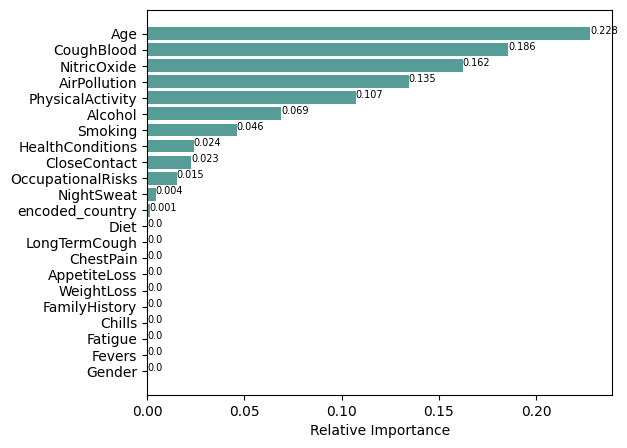

In [84]:
# Get feature importances from the Random Forest model
importances = DT_modelcv.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

### Random Forest

In [85]:
X4 = X.drop('tb_pred', axis=1)
Y4 = X['tb_pred'].values.ravel()

In [86]:
# Array of test size value from 0.2 to 0.3
test_size = np.arange(start=0.2, stop=0.35, step=0.05)

# Initialize a list where we'll store the score of each test size
score = []
for size in test_size:
    X_train3, X_test3, y_train3, y_test3= train_test_split (X4, Y4, test_size=size, random_state=0)
    RF_model = RandomForestClassifier ()
    RF_model.fit (X_train3, y_train3)
    score.append (RF_model.score (X_test3, y_test3))
    
# Create a dataframe to display the results   
r= pd.DataFrame({'Test size': test_size, 'Score': score})
r.sort_values(by = ['Score'], ascending = False, inplace = True)
r.style.highlight_max(color='#acd9a8')

,Test size,Score
2,0.300000,0.838333
1,0.250000,0.838000
0,0.200000,0.837500


In [87]:
# Split X and y into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X4, Y4, stratify=Y4, test_size = 0.25, random_state = 0)

In [88]:
# Instantiate the model
RF_model = RandomForestClassifier()

# Fit the model to the training set
RF_model.fit(X_train3, y_train3)

RandomForestClassifier()

In [89]:
y_pred4 = RF_model.predict(X_test3)
print('Model Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test3, y_pred4)))

Model Accuracy Score: 0.8420


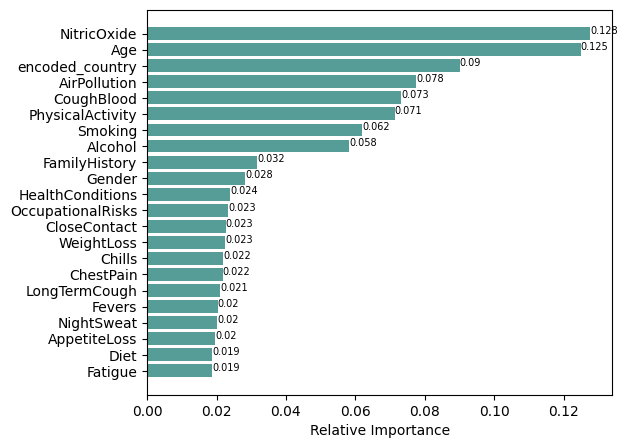

In [90]:
# Get the feature names and class names
fn = X4.columns
cn = ["0", "1", "2", "3"]

# Get feature importances from the Random Forest model
importances = RF_model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

In [91]:
from sklearn.model_selection import GridSearchCV

# define the AdaBoost model with default hyperparameters
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=0)

# define the hyperparameters to tune
params = {'n_estimators': [200, 500, 900], 'learning_rate': [0.1, 0.01, 1]}

# base_estimator__max_depth = [1, 2, 3, 4, 5]

# define the grid search using cross validation
grid_search = GridSearchCV(estimator=ada, param_grid=params, cv=10, scoring='accuracy')

# fit the grid search on the data
grid_search.fit(X_train, y_train)

# Set the clf to the best combination of parameters
AdaBoost = grid_search.best_estimator_

# print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'learning_rate': 0.1, 'n_estimators': 200}


In [92]:
# fit the AdaBoost model on the training set
AdaBoost.fit(X_train3, y_train3)

# make predictions on the test set and calculate and print the accuracy
predictions4 = AdaBoost.predict(X_test3)
accuracy = metrics.accuracy_score(predictions4, y_test3)
print('Accuracy of the AdaBoost on the test set:', accuracy)

# calculate and print the mean cross-validated score of the AdaBoost model
cross_val_scores = cross_val_score(AdaBoost, X_train3, y_train3, cv=10, scoring='accuracy')
print('The Cross-validated Score for AdaBoost is:', cross_val_scores.mean())

Accuracy of the AdaBoost on the test set: 0.794
The Cross-validated Score for AdaBoost is: 0.7833333333333333


In [93]:
AdaBoost_result = metrics_calculator(y_test3, predictions4, 'Tuned AdaBoost')
AdaBoost_result

,Tuned AdaBoost
Accuracy,0.794000
Precision,0.715928
Recall,0.699123
F1-score,0.706504


In [94]:
# Define the GradientBoosting model with default hyperparameters
grad = GradientBoostingClassifier(learning_rate=0.1, random_state=0)

# Define the hyperparameters to tune
parameters = {'n_estimators': [500, 900], 'max_depth': [5, 7]}

#learning_rate = [0.01, 0.1]
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]

# Create the grid search object
grid_search = GridSearchCV(grad, parameters, cv=10, scoring='accuracy')

# fit the grid search on the data
grid_search.fit(X_train3, y_train3)

# Set the clf to the best combination of parameters
Gradient_Boosting = grid_search.best_estimator_

# Print the results
print('Best parameters:', grid_search.best_params_)

Best parameters: {'max_depth': 5, 'n_estimators': 500}


In [95]:
# fit the GradientBoosting model on the training set
Gradient_Boosting.fit(X_train3, y_train3)

# make predictions on the test set and calculate and print the accuracy
predictions5 = Gradient_Boosting.predict(X_test3)
accuracy = metrics.accuracy_score(predictions5, y_test3)
print('Accuracy of the GradientBoosting on the test set:', accuracy)

# calculate and print the mean cross-validated score of the GradientBoosting model
cross_val_scores = cross_val_score(Gradient_Boosting, X_train3, y_train3, cv=10, scoring='accuracy')
print('The Cross-validated Score for GradientBoosting is:', cross_val_scores.mean())

Accuracy of the GradientBoosting on the test set: 0.89
The Cross-validated Score for GradientBoosting is: 0.8833333333333334


In [96]:
GradientBoosting_result = metrics_calculator(y_test3, predictions5, 'Tuned Gradient Boosting')
GradientBoosting_result

,Tuned Gradient Boosting
Accuracy,0.890000
Precision,0.862427
Recall,0.825000
F1-score,0.841289


## We will be using the gradient boosting classifier.

In [ ]:
import numpy as np
import pandas as pd 

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score